In [1]:
%pip install sqlalchemy psycopg2-binary pandas python-dotenv "elasticsearch==8.7.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 5.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB ? eta 0:00:000:00:0100:13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 1.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 766.9 kB/s eta 0:00:000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:0000:0100:01�━━━━━━━━━━━━━╺

In [2]:

import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from typing import Optional



# --- Config DB ---
DB_HOST = os.getenv("PGHOST", "postgres")   # 'postgres' si estás en el mismo docker network; 'localhost' si ejecutas fuera
DB_PORT = int(os.getenv("PGPORT", "5432"))
DB_NAME = os.getenv("PGDATABASE", "bbdd_api_youtube")
DB_USER = os.getenv("PGUSER", "postgres")
DB_PASS = os.getenv("PGPASSWORD", "postgres")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

def run_query(sql: str, params: Optional[dict] = None) -> pd.DataFrame:
    with engine.connect() as conn:
        df = pd.read_sql(text(sql), conn, params=params)
    return df

print(f"Conectando a {DB_NAME}@{DB_HOST}:{DB_PORT} como {DB_USER} ... listo.")


Conectando a bbdd_api_youtube@postgres:5432 como postgres ... listo.


Filas: 7


,channel,avg_dur_min,avg_likes,avg_comments,ratio_likes,ratio_comments
0,Mathologer,24.464583,15846.125000,1484.178571,0.001544,0.016484
1,El Traductor de Ingeniería,22.290854,16791.133574,514.003610,0.001328,0.043367
2,3Blue1Brown,15.008482,95621.250000,2191.343750,0.000157,0.006849
3,QuantumFracture,10.992704,76055.049057,1890.266038,0.000145,0.005815
4,Veritasium,10.962942,206185.488938,10329.506637,0.000053,0.001061
5,ElectroBOOM,7.970275,155205.370370,3774.706553,0.000051,0.002111
6,BBC Timestamp,6.611576,2024.000000,187.187192,0.003267,0.035321


<Figure size 640x480 with 0 Axes>

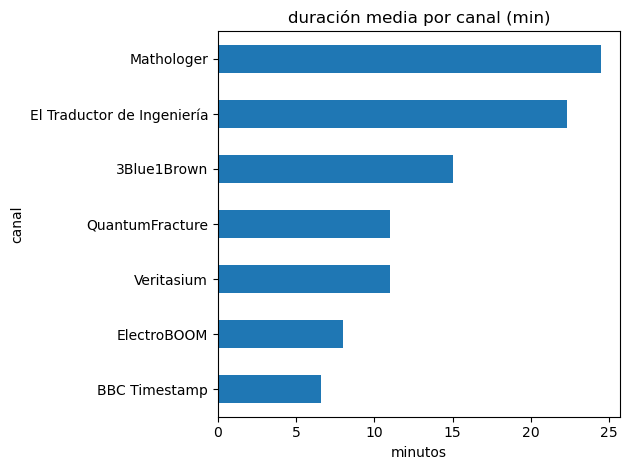

In [ ]:

sql_1 = """
-- con los ratios de comments y likes por duración de video
WITH per_channel_base AS (
  SELECT
    c.name AS channel,
    ROUND((AVG(v.duration)::float / 60.0)::numeric, 2) AS avg_dur_min,
    ROUND((AVG(v.like_count)::float)::numeric, 2)      AS avg_likes,
    ROUND((AVG(v.comment_count)::float)::numeric, 2)   AS avg_comments
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.duration IS NOT NULL
    AND v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
  GROUP BY c.name
),
per_channel AS (
  SELECT
    channel,
    avg_dur_min,
    avg_likes,
    avg_comments,
    avg_dur_min / NULLIF(avg_likes,0)    AS ratio_likes,
    avg_dur_min / NULLIF(avg_comments,0) AS ratio_comments
  FROM per_channel_base
)
SELECT *
FROM per_channel
ORDER BY avg_dur_min DESC;
"""
df_ratios = run_query(sql_1)
print("Filas:", len(df_ratios))
display(df_ratios.head(20))

# (Opcional) gráfico rápido: duración media por canal (top 20)
plt.figure()
df_ratios.sort_values("avg_dur_min", ascending=False).head(20).plot(
    x="channel", y="avg_dur_min", kind="barh", legend=False
)
plt.title("duración media por canal (min)")
plt.xlabel("minutos")
plt.ylabel("canal")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:

sql_2 = """
WITH base AS (
  SELECT
    c.name                       AS channel,
    v.like_count::float          AS likes,
    v.comment_count::float       AS comments,
    CASE
      WHEN EXTRACT(MONTH FROM v.published_at) IN (7,8) THEN 'vacaciones'
      ELSE 'escolar'
    END                          AS periodo
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
    AND v.published_at IS NOT NULL
)
SELECT
  channel,
  periodo,
  ROUND((corr(likes, comments))::numeric,3)  AS r_pearson,
  COUNT(*)               AS n
FROM base
GROUP BY channel, periodo
HAVING COUNT(*) >= 5           -- mínimo tamaño muestral
ORDER BY channel, periodo;
"""
df_corr = run_query(sql_2)
print("Filas:", len(df_corr))
display(df_corr.head(30))

'''
# (Opcional) ejemplo de selección: canales con >= 20 observaciones por periodo y |r| >= 0.5
df_corr_sig = df_corr[(df_corr["n"] >= 20) & (df_corr["r_pearson"].abs() >= 0.5)].sort_values(["channel","periodo"])
display(df_corr_sig.head(30))

# (Opcional) gráfico: r por canal en periodo 'escolar' (top |r|)
try:
    df_escolar = df_corr[df_corr["periodo"]=="escolar"].dropna(subset=["r_pearson"])
    top = df_escolar.reindex(df_escolar.r_pearson.abs().sort_values(ascending=False).index).head(20)
    plt.figure()
    top.plot(x="channel", y="r_pearson", kind="barh", legend=False)
    plt.title("correlación likes–comentarios (periodo escolar) – top |r|")
    plt.xlabel("coeficiente de pearson r")
    plt.ylabel("canal")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("No se pudo graficar:", e)
'''    


Filas: 14


,channel,periodo,r_pearson,n
0,3Blue1Brown,escolar,0.547650,193
1,3Blue1Brown,vacaciones,0.913607,31
2,BBC Timestamp,escolar,0.879604,136
3,BBC Timestamp,vacaciones,0.827928,67
4,ElectroBOOM,escolar,0.348754,298
5,ElectroBOOM,vacaciones,0.362306,53
6,El Traductor de Ingeniería,escolar,0.872913,221
7,El Traductor de Ingeniería,vacaciones,0.764430,56
8,Mathologer,escolar,0.595940,93
9,Mathologer,vacaciones,0.923612,19


'\n# (Opcional) ejemplo de selección: canales con >= 20 observaciones por periodo y |r| >= 0.5\ndf_corr_sig = df_corr[(df_corr["n"] >= 20) & (df_corr["r_pearson"].abs() >= 0.5)].sort_values(["channel","periodo"])\ndisplay(df_corr_sig.head(30))\n\n# (Opcional) gráfico: r por canal en periodo \'escolar\' (top |r|)\ntry:\n    df_escolar = df_corr[df_corr["periodo"]=="escolar"].dropna(subset=["r_pearson"])\n    top = df_escolar.reindex(df_escolar.r_pearson.abs().sort_values(ascending=False).index).head(20)\n    plt.figure()\n    top.plot(x="channel", y="r_pearson", kind="barh", legend=False)\n    plt.title("correlación likes–comentarios (periodo escolar) – top |r|")\n    plt.xlabel("coeficiente de pearson r")\n    plt.ylabel("canal")\n    plt.gca().invert_yaxis()\n    plt.tight_layout()\n    plt.show()\nexcept Exception as e:\n    print("No se pudo graficar:", e)\n'

In [ ]:
sql_franjas = """
WITH base AS (
  SELECT
    v.id,
    v.like_count,
    v.comment_count,
    /* Ajusta si tu published_at NO está en UTC */
    ((v.published_at AT TIME ZONE 'UTC') AT TIME ZONE 'Europe/Madrid') AS published_local
  FROM public.video v
  WHERE v.published_at IS NOT NULL
)
SELECT
  CASE
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 0  AND 5  THEN '00-06'
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 6  AND 11 THEN '06-12'
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 12 AND 17 THEN '12-18'
    ELSE '18-24'
  END AS franja_horaria,

  COUNT(*) AS num_videos,

  ROUND((AVG((like_count::float) / NULLIF(comment_count, 0)))::numeric, 2) AS avg_likes_por_comentario,
  ROUND(STDDEV_SAMP((like_count::float) / NULLIF(comment_count, 0))::numeric, 2) AS sd_likes_por_comentario,

  ROUND(AVG(like_count::float)::numeric, 2)    AS avg_likes,
  ROUND(STDDEV_SAMP(like_count::float)::numeric, 2) AS sd_likes,

  ROUND(AVG(comment_count::float)::numeric, 2) AS avg_comments,
  ROUND(STDDEV_SAMP(comment_count::float)::numeric, 2) AS sd_comments

FROM base
GROUP BY franja_horaria
ORDER BY franja_horaria;
"""

df_franjas = run_query(sql_franjas)
print("Filas:", len(df_franjas))
display(df_franjas)


Filas: 4


,franja_horaria,num_videos,avg_likes_por_comentario,sd_likes_por_comentario,avg_likes,sd_likes,avg_comments,sd_comments
0,00-06,190,49.329360,56.590537,82007.831579,221613.220894,2122.915789,3803.005456
1,06-12,80,39.419072,52.721181,74857.662500,227693.078327,2456.812500,5298.124113
2,12-18,836,57.990259,74.625693,105156.526316,181161.871010,4096.500000,8597.602148
3,18-24,1043,48.619548,62.080286,102355.788111,195951.453209,3651.576222,8075.825592


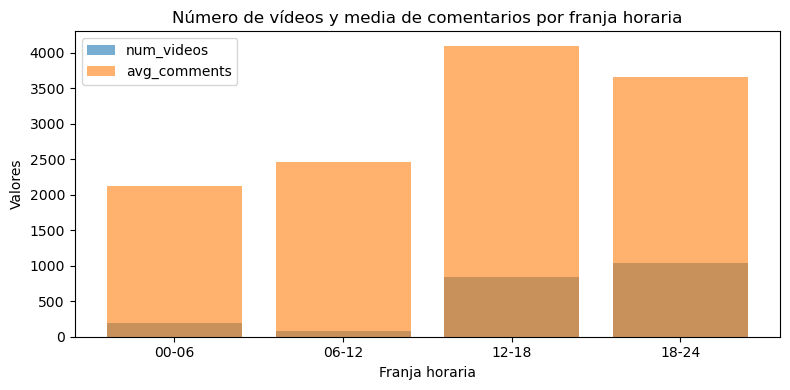

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

# primera serie
ax.bar(
    df_franjas["franja_horaria"],
    df_franjas["num_videos"],
    label="num_videos",
    alpha=0.6
)

# segunda serie
ax.bar(
    df_franjas["franja_horaria"],
    df_franjas["avg_comments"],
    label="avg_comments",
    alpha=0.6
)

ax.set_title("Número de vídeos y media de comentarios por franja horaria")
ax.set_xlabel("Franja horaria")
ax.set_ylabel("Valores")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from elasticsearch import Elasticsearch
import pandas as pd

es = Elasticsearch("http://elasticsearch:9200")
print(es.info().body["version"])

In [5]:

## Busqueda de aquellos videos mas similares a un nuevo video con un topic nuevo tambien 

def similares_por_contenido(title: str, topic_or_desc: str, size: int = 10):
    q = {
        "size": size,
        "_source": ["id","title_raw","topic","language","duration_seconds",
                    "view_count","like_count","published_at","id_channel"],
        "query": {
            "multi_match": {
                "query": f"{title}\n{topic_or_desc or ''}",
                "fields": ["title_raw^2","topic"],  # pesa más el título
                "type": "best_fields"
            }
        }
    }
    res = es.search(index="videos", body=q)
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"]]
    return pd.DataFrame(rows)

df = similares_por_contenido("Introducción a matrices", "álgebra lineal, operaciones básicas", size=15)
df.head()

{'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}


/tmp/ipykernel_121/799091655.py:21: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="videos", body=q)


,score,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel
0,15.016190,3hCJILOpvWA,🚀Circuitos ELÉCTRICOS: Introducción al Régimen...,925,"This are the details of a youtube video, gener...",2025-08-24T20:21:59,17405,1171,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
1,12.562542,e5NDNgCfVs8,📚 ¡MATEMÁTICA sin MEMORIZAR! - Clase #2: Opera...,5480,"This are the details of a youtube video, gener...",2024-03-10T08:55:35,207876,9131,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
2,11.367714,kYB8IZa5AuE,Linear transformations and matrices | Chapter ...,659,Linear transformations and matrices | Chapter ...,2016-08-07T21:39:19,6271357,133201,en-US,UCYO_jab_esuFRV4b17AJtAw
3,10.921768,HtWh2S5L0A8,📖 Luego del Reto Viral 8:2*(2+2) ¿JERARQUÍA DE...,653,No summary avaliable,2019-08-11T01:30:08,152344,10136,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
4,10.377901,v8VSDg_WQlA,Nonsquare matrices as transformations between ...,267,Nonsquare matrices as transformations between ...,2016-08-16T21:59:23,1849382,33610,en-US,UCYO_jab_esuFRV4b17AJtAw


In [ ]:
from sentence_transformers import SentenceTransformer

def similares_por_contenido(title: str, topic_or_desc: str = "", size: int = 10):
    # Cargar el modelo de sentence-transformers
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Combinar título y topic/descripción para la consulta
    query_text = f"{title} {topic_or_desc}" if topic_or_desc else title
    
    # Generar el embedding para el texto de consulta
    query_embedding = model.encode([query_text])[0].tolist()
    
    # Buscar videos similares usando knn
    query = {
        "knn": {
            "field": "title_embedding",
            "query_vector": query_embedding,
            "k": size,
            "num_candidates": 100
        },
        "_source": ["id", "title_raw", "topic", "language", "duration_seconds",
                   "view_count", "like_count", "published_at", "id_channel"]
    }
    
    res = es.search(
        index="videos",
        body=query,
        size=size
    )
    
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"]]
    return pd.DataFrame(rows)

# Ejemplo de uso
df = similares_por_contenido("Introducción a matrices", "álgebra lineal, operaciones básicas", size=15)
df.head()

In [8]:
## Busqueda de los videos mas similares a un video de su mismo canal

def similares_en_canal(video_id, size=10):
    doc = es.get(index="videos", id=video_id)["_source"]
    q = {
        "size": size,
        "_source": True,
        "query": {
            "bool": {
                "filter": [
                    {"term": {"id_channel": doc["id_channel"]}}
                ],
                "should": [
                    {"match": {"topic": doc["topic"]}},
                    {"match": {"title_raw": {"query": doc["title_raw"], "boost": 2}}}
                ]
            }
        }
    }
    res = es.search(index="videos", body=q)
    return pd.DataFrame([h["_source"] for h in res["hits"]["hits"]])


In [12]:
df_similares = similares_en_canal("4tgOyU34D44")
df_similares

/tmp/ipykernel_121/3374389592.py:18: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="videos", body=q)


,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel
0,4tgOyU34D44,How To See Air Currents,392,How To See Air Currents,2017-06-15T12:00:00,1592695,81465,en,UCHnyfMqiRRG1u-2MsSQLbXA
1,kh9OmFBg8qI,How To See Atoms,64,How To See Atoms,2025-10-17T13:00:04,8331413,215342,en,UCHnyfMqiRRG1u-2MsSQLbXA
2,w5ebcowAJD8,I built a QR code with my bare hands to see ho...,2113,I built a QR code with my bare hands to see ho...,2024-09-30T18:51:21,8868808,267777,en,UCHnyfMqiRRG1u-2MsSQLbXA
3,ovJcsL7vyrk,This equation will change how you see the worl...,1119,This equation will change how you see the worl...,2020-01-29T19:35:46,16721868,604056,en,UCHnyfMqiRRG1u-2MsSQLbXA
4,PifL8bAybyc,How To Make Graphene,221,How To Make Graphene,2011-12-19T10:35:12,2686578,57034,en,UCHnyfMqiRRG1u-2MsSQLbXA
5,q6WlXhtVvkg,How to solve any maze,176,How to solve any maze,2025-09-18T13:00:02,6961711,332671,en,UCHnyfMqiRRG1u-2MsSQLbXA
6,h830G5mkTF4,How To Solve a Quadratic Equation,154,How To Solve a Quadratic Equation,2025-10-26T13:32:19,3312303,109796,en,UCHnyfMqiRRG1u-2MsSQLbXA
7,Q51-gLL_MRM,How To Earthquake-Proof A House,1143,How To Earthquake-Proof A House,2023-12-19T15:16:53,2288501,78045,en,UCHnyfMqiRRG1u-2MsSQLbXA
8,knDIENvBTgw,How to Launch a Nuclear Missile,461,How to Launch a Nuclear Missile,2015-07-27T15:00:02,4961345,125139,en,UCHnyfMqiRRG1u-2MsSQLbXA
9,zNzzGgr2mhk,How To Make a Quantum Bit,471,How To Make a Quantum Bit,2013-07-23T15:16:32,1780939,45974,en,UCHnyfMqiRRG1u-2MsSQLbXA


In [13]:

def similares_en_canal(video_id, size=10):
    doc = es.get(index="videos", id=video_id)["_source"]
    q = {
        "size": size,
        "_source": ["id","id_channel","title_raw","topic","language","duration_seconds","view_count","like_count","published_at"],
        "query": {
            "bool": {
                "filter": [{"term": {"id_channel": doc["id_channel"]}}],
                "should": [
                    {"match": {"topic": doc.get("topic","")}},
                    {"match": {"title_raw": {"query": doc.get("title_raw",""), "boost": 2}}}
                ],
                "minimum_should_match": 1
            }
        }
    }
    res = es.search(index="videos", body=q)
    vids = [h["_id"] for h in res["hits"]["hits"] if h["_id"] != video_id]
    df = pd.DataFrame([{**h["_source"], "id_video": h["_id"], "_score": h["_score"]} for h in res["hits"]["hits"]])
    return vids, df

def _comentarios_de_video(video_id, max_docs=50):
    q = {
        "size": max_docs,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {"term": {"id_video": video_id}}
    }
    res = es.search(index="comments", body=q)
    return [h["_source"]["text"] for h in res["hits"]["hits"] if h["_source"].get("text")]

def comentarios_similares_entre_videos_similares(video_id, size=50, semillas_max=80, candidatos_por_video=200):
    # 1) vídeos similares
    similar_ids, df_videos = similares_en_canal(video_id, size=10)
    if not similar_ids:
        return pd.DataFrame(), df_videos

    # 2) semillas: comentarios del vídeo origen (varios textos)
    semillas = _comentarios_de_video(video_id, max_docs=semillas_max)
    if not semillas:  # si el vídeo no tiene comentarios, usa título+tema como “semilla”
        vsrc = es.get(index="videos", id=video_id)["_source"]
        semillas = [f"{vsrc.get('title_raw','')} {vsrc.get('topic','')}"]

    # 3) búsqueda MLT en comments, filtrando por vídeos similares
    q = {
        "size": size,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {
            "bool": {
                "filter": [{"terms": {"id_video": similar_ids}}],
                "must": {
                    "more_like_this": {
                        "fields": ["text"],
                        "like": [{"doc": {"text": t}} for t in semillas],
                        "min_term_freq": 1,
                        "min_doc_freq": 1,
                        "max_query_terms": 50
                    }
                }
            }
        }
    }
    res = es.search(index="comments", body=q)
    rows = []
    for h in res["hits"]["hits"]:
        src = h["_source"]
        rows.append({
            "score": h["_score"],
            "comment_id": src.get("id"),
            "id_video": src.get("id_video"),
            "text": src.get("text"),
            "published_at": src.get("published_at"),
            "like_count": src.get("like_count"),
            "sentiment_score": src.get("sentiment_score"),
        })
    df_comentarios = pd.DataFrame(rows)

    return df_comentarios, df_videos

def comentarios_similares_a_un_comentario(comment_id, size=50):
    # semilla: el propio comentario
    c = es.get(index="comments", id=comment_id)["_source"]
    video_id = c["id_video"]

    # vídeos similares al del comentario
    similar_ids, df_videos = similares_en_canal(video_id, size=10)
    if not similar_ids:
        return pd.DataFrame(), df_videos

    q = {
        "size": size,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {
            "bool": {
                "filter": [{"terms": {"id_video": similar_ids}}],
                "must": {
                    "more_like_this": {
                        "fields": ["text"],
                        "like": [{"_index": "comments", "_id": comment_id}],
                        "min_term_freq": 1,
                        "min_doc_freq": 1,
                        "max_query_terms": 50
                    }
                },
                "must_not": [{"term": {"_id": comment_id}}]
            }
        }
    }
    res = es.search(index="comments", body=q)
    rows = [{
        "score": h["_score"],
        "comment_id": h["_source"]["id"],
        "id_video": h["_source"]["id_video"],
        "text": h["_source"]["text"],
        "published_at": h["_source"].get("published_at"),
        "like_count": h["_source"].get("like_count"),
        "sentiment_score": h["_source"].get("sentiment_score"),
    } for h in res["hits"]["hits"]]
    return pd.DataFrame(rows), df_videos


In [16]:
df_comentarios, df_videos_similares = comentarios_similares_entre_videos_similares(video_id="4tgOyU34D44")
print(df_comentarios.head(10))


       score                  comment_id     id_video  \
0  23.616297  Ugwz6kH-FmPmOhKJPtd4AaABAg  zNzzGgr2mhk   

                                                text published_at  like_count  \
0  No, it wouldn't take "minutes"\r\n\r\nIf you h...   2025-06-14           0   

   sentiment_score  
0                3  


/tmp/ipykernel_121/3987778047.py:17: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="videos", body=q)
/tmp/ipykernel_121/3987778047.py:28: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="comments", body=q)
/tmp/ipykernel_121/3987778047.py:62: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="comments", body=q)


In [17]:
print(df_videos_similares.head(10))

            id                                          title_raw  \
0  4tgOyU34D44                            How To See Air Currents   
1  kh9OmFBg8qI                                   How To See Atoms   
2  w5ebcowAJD8  I built a QR code with my bare hands to see ho...   
3  ovJcsL7vyrk  This equation will change how you see the worl...   
4  PifL8bAybyc                               How To Make Graphene   
5  q6WlXhtVvkg                              How to solve any maze   
6  h830G5mkTF4                  How To Solve a Quadratic Equation   
7  Q51-gLL_MRM                    How To Earthquake-Proof A House   
8  knDIENvBTgw                    How to Launch a Nuclear Missile   
9  zNzzGgr2mhk                          How To Make a Quantum Bit   

   duration_seconds                                              topic  \
0               392                            How To See Air Currents   
1                64                                   How To See Atoms   
2              211

In [21]:
df_comments, df_videos = comentarios_similares_a_un_comentario("UgyBUfIkQCf8wvDoTux4AaABAg")


/tmp/ipykernel_121/3987778047.py:17: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="videos", body=q)
/tmp/ipykernel_121/3987778047.py:108: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index="comments", body=q)


In [23]:
print("COMENTARIOS SIMILARES:")
display(df_comments)

print("VIDEOS SIMILARES:")
display(df_videos_similares)

COMENTARIOS SIMILARES:


,score,comment_id,id_video,text,published_at,like_count,sentiment_score
0,18.583420,Ugyia5gVnU7BgBLe7YR4AaABAg,ESveYNa4OMk,"HEEE !!!! un momento ,,,los planetas son esfe...",2025-06-14,0,5
1,14.539654,UgwjlO77r2MR-yGRbvV4AaABAg,wmvZbyOCFd4,Hola amigo tengo 2 tesis que demuestran 2 movi...,2025-08-17,0,3
2,13.038719,Ugx2gQWUWc7HCnhZQjR4AaABAg,5WZb_xCX2KQ,Es importante informarse bien sobre el tema co...,2024-10-30,0,3
3,12.874792,UgzzQ5agp4IY-HmWRIZ4AaABAg,5WZb_xCX2KQ,El horóscopo que crees que eres no es ya que e...,2024-11-23,1,2
4,12.552361,UgyzEr-mmicypgQRXD14AaABAg,G6A_Zh7lpoM,2:15 Pues si ya no se pueden usar telescopios ...,2025-04-28,0,3
5,10.629751,UgwFPaprmVDpZw3Lhbd4AaABAg,iExj0mk1Wno,"No es solo azul. Por la noche es negro, si tie...",2025-04-16,0,2
6,10.526012,UgwFdFVWMKcYa7FwODZ4AaABAg,pqEidVW9da0,Y la semana que viene resolveremos de una vez ...,2021-05-23,4268,3
7,10.157432,UgyEGrWiuJl78p_IXWp4AaABAg,ESveYNa4OMk,Pero cómo pueden curvarse conceptos humanos lo...,2025-07-02,0,2
8,9.963725,UgzhT6wGP4DyGgWDKfJ4AaABAg,5WZb_xCX2KQ,La astrología es mucho más compleja que este v...,2024-09-09,0,2
9,9.679243,UgxDzhVy9wj5Vv5ir8J4AaABAg,5WZb_xCX2KQ,"La astrologia tiene sus defectos sin duda, por...",2025-07-13,0,1


VIDEOS SIMILARES:


,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel,id_video,_score
0,4tgOyU34D44,How To See Air Currents,392,How To See Air Currents,2017-06-15T12:00:00,1592695,81465,en,UCHnyfMqiRRG1u-2MsSQLbXA,4tgOyU34D44,86.473740
1,kh9OmFBg8qI,How To See Atoms,64,How To See Atoms,2025-10-17T13:00:04,8331413,215342,en,UCHnyfMqiRRG1u-2MsSQLbXA,kh9OmFBg8qI,40.347180
2,w5ebcowAJD8,I built a QR code with my bare hands to see ho...,2113,I built a QR code with my bare hands to see ho...,2024-09-30T18:51:21,8868808,267777,en,UCHnyfMqiRRG1u-2MsSQLbXA,w5ebcowAJD8,25.596764
3,ovJcsL7vyrk,This equation will change how you see the worl...,1119,This equation will change how you see the worl...,2020-01-29T19:35:46,16721868,604056,en,UCHnyfMqiRRG1u-2MsSQLbXA,ovJcsL7vyrk,20.770393
4,PifL8bAybyc,How To Make Graphene,221,How To Make Graphene,2011-12-19T10:35:12,2686578,57034,en,UCHnyfMqiRRG1u-2MsSQLbXA,PifL8bAybyc,20.528822
5,q6WlXhtVvkg,How to solve any maze,176,How to solve any maze,2025-09-18T13:00:02,6961711,332671,en,UCHnyfMqiRRG1u-2MsSQLbXA,q6WlXhtVvkg,19.398207
6,h830G5mkTF4,How To Solve a Quadratic Equation,154,How To Solve a Quadratic Equation,2025-10-26T13:32:19,3312303,109796,en,UCHnyfMqiRRG1u-2MsSQLbXA,h830G5mkTF4,18.389645
7,Q51-gLL_MRM,How To Earthquake-Proof A House,1143,How To Earthquake-Proof A House,2023-12-19T15:16:53,2288501,78045,en,UCHnyfMqiRRG1u-2MsSQLbXA,Q51-gLL_MRM,18.389645
8,knDIENvBTgw,How to Launch a Nuclear Missile,461,How to Launch a Nuclear Missile,2015-07-27T15:00:02,4961345,125139,en,UCHnyfMqiRRG1u-2MsSQLbXA,knDIENvBTgw,18.389645
9,zNzzGgr2mhk,How To Make a Quantum Bit,471,How To Make a Quantum Bit,2013-07-23T15:16:32,1780939,45974,en,UCHnyfMqiRRG1u-2MsSQLbXA,zNzzGgr2mhk,18.389645
